# Trixi: Coupled Complex Advection Equations with Nonlinear Source Term

This example is based off the `Trixi.jl` tutorial: 

https://trixi-framework.github.io/Trixi.jl/stable/tutorials/non_periodic_boundaries/

This notebook goes over solving 1D two complex variable advection equations. The system is separated into its real and imaginary parts which forms a system of four real variable advection equations. 

In [1]:
VERSION

v"1.11.1"

uncomment the line below to add any packages

In [2]:
# ] add LinearSolve

Activate project

In [3]:
using Pkg
Pkg.activate(".")

  Activating project at `~/TRIXI`


In [4]:
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("Trixi")
# Pkg.add("Plots")
# Pkg.add("LinearSolve")
# Pkg.add("LaTeXStrings")

In [5]:
#import julia libraries
using OrdinaryDiffEq
using Trixi
using Plots
using LaTeXStrings
using LinearSolve

# 1D Nonlinear Advection Equations

1D Coupled Advection equations: 

\begin{equation}
    \partial_{t} A_{0} + \mathbf{c}_{0}\cdot \nabla A_{0} = R_{0} \left|  A_{s} \right|^{2} A_{0}
    \tag{1}
\end{equation}

\begin{equation}
    \partial_{t} A_{s} + \mathbf{c}_{s}\cdot \nabla A_{s}  = R_{s} \left|  A_{0} \right|^{2} A_{s}
    \tag{2}
\end{equation}

where $A_{0}$ is the pump amplitude, $A_{s}$ the scattered wave amplitude,  $\mathbf{c}$ denotes the velocity of the wave, $\left|  A \right|^{2}$ denotes the intensity, and $R_{0}$, $R_{s}$ denote the gain factors for the pump and scattered waves, respectively.

And, for 1D:

\begin{equation}
    \nabla \Rightarrow \frac{\partial}{\partial x}
\end{equation}

We need to split our equations up into **Real** and **Imaginary** parts. 

\begin{equation}
    \begin{aligned}
    A_{0} &= A_{0,r} + i A_{0,i} \\
    A_{s} &= A_{s,r} + i A_{s,i}
    \end{aligned}
    \tag{3}
\end{equation}

The gain factors also have real and imaginary part: 

\begin{equation}
    \begin{aligned}
    R_{0} &= R_{0,r} + i R_{0,i} \\
    R_{s} &= R_{s,r} + i R_{s,i}
    \end{aligned}
    \tag{4}
\end{equation}

Our equations then become:

\begin{equation}
    \partial_{t} \left(  A_{0,r} + i A_{0,i} \right) + \mathbf{c}_{0} \cdot \nabla \left(  A_{0,r} + i A_{0,i} \right)  = \left(R_{0,r} + i R_{0,i} \right) \left| \left(  A_{s,r} + i A_{s,i}  \right) \right|^{2} \left(  A_{0,r} + i A_{0,i} \right)
    \tag{5}
\end{equation}

\begin{equation}
    \partial_{t}\left(  A_{s,r} + i A_{s,i}  \right) + \mathbf{c}_{s}\cdot \nabla \left(  A_{s,r} + i A_{s,i}  \right) = \left(R_{s,r} + i R_{s,i} \right) \left|   \left(  A_{0,r} + i A_{0,i} \right) \right|^{2} \left(  A_{s,r} + i A_{s,i}  \right)
    \tag{6}
\end{equation}

Separating into the real and imaginary parts: 

For the pump:

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{0,r} + \mathbf{c}_{0} \cdot \nabla   A_{0,r} &= R_{0,r} \left| A_{s}  \right|^{2}  A_{0,r} - R_{0,i} \left| A_{s}  \right|^{2}  A_{0,i}\\
    \partial_{t}   A_{0,i} + \mathbf{c}_{0}\cdot \nabla   A_{0,i} &= R_{0,r} \left| A_{s}  \right|^{2}  A_{0,i} + R_{0,i} \left| A_{s}  \right|^{2}  A_{0,r} 
    \end{aligned}
    \tag{7}
\end{equation}

For the seed: 

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{s,r} + \mathbf{c}_{s}\cdot \nabla   A_{s,r} &= R_{s,r} \left| A_{0}  \right|^{2}  A_{s,r} - R_{s,i} \left| A_{0}  \right|^{2}  A_{s,i}\\
    \partial_{t}   A_{s,i} + \mathbf{c}_{s}\cdot \nabla   A_{s,i} &= R_{s,r} \left| A_{0}  \right|^{2}  A_{s,i} + R_{s,i} \left| A_{0}  \right|^{2}  A_{s,r} 
    \end{aligned}
    \tag{8}
\end{equation}


We will set velocity of the waves to be normalized. The pump wave to move from left to right in the positive x-direction so $\mathbf{c}_{0} = 1$. The seed wave will move from right to left in the negative x-direction so $\mathbf{c}_{s} = -1$

\begin{equation}
    \begin{aligned}
    \mathbf{c}_{0} &= 1 \\
    \mathbf{c}_{s} &= -1
    \end{aligned}
    \tag{9}
\end{equation}

The gain factors will be:

\begin{equation}
    \begin{aligned}
    R_{0,r} &= -0.9340923747649682 \\
    R_{0,i} &= -0.10025886956814646\\ 
    R_{s,r} &= 0.934090615327568 \\ 
    R_{s,i} &= -0.10025868072257872
    \end{aligned}
    \tag{10}
\end{equation}

In [6]:
c0 = 1.0
cs = -1.0
R0r = -0.9340923747649682
R0i = -0.10025886956814646
Rsr = 0.934090615327568
Rsi = -0.10025868072257872


-0.10025868072257872

We'll start the initial amplitudes as:

In [7]:
A0 = 38.0
As = 3.80

3.8

# Initial Conditions

THe initial conditions will be a gaussian beam of the form from Powers Eqn 2.124: 

\begin{equation}
    \mathbf{E}\left( z,r_{\perp},t \right) = \frac{A_0}{2} \exp{\left( -\frac{\alpha x}{2}  \right)} \frac{w_{0}}{w\left( z \right)}\:  \exp{\left( \frac{ -r_{\perp}^2}{w^2(z)} \right)} \:\exp{\left( i k_{0} \frac{r^{2}_{\perp}}{2 R\left( z\right)} - i \zeta \left( z \right) \right)}  \: \exp{\left( \frac{\left( z/c - t  \right)^{2}}{\tau^{2}_{0}} \right)}     \cos{\left( \omega_{0} t - k_{0} z  \right)} \: \hat{E} 
    \tag{11}
\end{equation}

where the variable $z$ is the longitudinal direction and $r_{\perp}$ is the transverse direction, and $\alpha$ is the medium's absorption coefficient. In this example, we choose $\alpha = 0$, so no absorption by the medium since it is vacuum.

Taking the 1D along the x-direction without the oscillatory factor becuase of the Paraxial SVEA with no initial absorption:

\begin{equation}
    \mathbf{A}\left( z,0,t \right) = \frac{A_0}{2} \frac{w_{0}}{w\left(z \right)} \:\exp{\left(  - i \zeta \left( z\right) \right)}  \: \exp{\left( -\frac{\left( z/c - t  \right)^{2}}{\tau^{2}_{0}} \right)}
    \tag{12}
\end{equation}

We can also define this for a supergaussian beam: 

\begin{equation}
    \mathbf{A}\left( z,0,t \right) = \frac{A_0}{2} \frac{w_{0}}{w\left( z \right)} \:\exp{\left(  - i \zeta \left( z \right) \right)}  \: \exp{ \left[ - \left( \frac{\left( z/c - t  \right)^{2}}{\tau^{2}_{0}} \right)^{m} \right] }
    \tag{13}
\end{equation}

where the exponential $m$ is the supergaussian order.

The $w\left( z \right)$ represents the $1/e$ field amplitude radius:

\begin{equation}
    w\left( z \right) = w_{0} \sqrt{1 + \frac{z}{z_{R}}}
    \tag{14}
\end{equation}

$w_{0}$ is the beam waist radius at $z=0$ (the focus), and $z_{R}$ is the rayleigh length described by: 

\begin{equation}
    z_{R} = \frac{\pi n w^{2}_{0}}{\lambda}
    \tag{15}
\end{equation}

and $n$ is the index of refraction.



The radius of curvature is defined as:

\begin{equation}
    R\left( z \right) = z \left( 1 + \left( \frac{z_{R}}{z} \right)^{2}  \right)
    \tag{16}
\end{equation}

the Guoy phase shift is define as: 

\begin{equation}
    \zeta \left( z \right) = \tan^{-1}{\left( z/z_{R} \right)}  
    \tag{17}
\end{equation}

Lastly, $\tau_{0}$ is the $1/e$ temporal pulse width. 

In this example, let's assume our beam starts at: $z = 0$, at the focus. 

We can calculate $w_{0}$ and $\tau_{0}$ from the beamwidth Full-Width-Half-Max (FWHM) $r_{FWHM}$ and the temporal pulsewidth $t_{FWHM}$,  formulation via: 

\begin{equation}
    \begin{aligned}
    \tau_{0} &= t_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } \\
    w_{0} &= r_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} } 
    \end{aligned}
\end{equation}

and for a supergaussian: 

\begin{equation}
    \tau_{0} = t_{FWHM}/\sqrt{ 2 \ln{\left(2 \right)} }
\end{equation}

The temporal pulsewidth ($t_{FWHM}$) is the full-width-half-max of the intensity. Given $t_{FWHM}$, one can calculate the gaussian parameter ($\tau_{0}$) as follows:

Given an amplitude with the form: 

\begin{equation}
    A\left( t \right) = A_{0} \exp{\left[- \left(   \frac{t}{\tau_0}  \right)^{m}   \right]}
    \tag{18}
\end{equation}

where $m$ is the superguassian order ($m=2$ is a regular gaussian function). $t_{FWHM}$ is defined in terms of the intensity, so we need to square Equation 34:

\begin{equation}
    I\left( t \right) = A_{0}^{2} \exp{\left[- 2\left(   \frac{t}{\tau_0}  \right)^{m}   \right]}
    \tag{19}
\end{equation}

Now the FWHM is when the Intensity reaches half it's maximum value. Assuming the maximum value is $I_{max} = A_{0}^{2}$, at time $t = t_{FWHM}/2$, the pulse will reach half the maximum value. We use $t = t_{FWHM}/2$ because $t_{FWHM}$ spans both sides of the pulse. Pluggin in and dividing by $I_{max}$ and solving:

\begin{equation}
    \begin{aligned}
    \frac{1}{2} &= \exp{\left[- 2\left(   \frac{t_{FWHM}/2}{\tau_0}  \right)^{m}   \right]} \\
    & \\
    \ln{ \left( \frac{1}{2}  \right)} &= \left[- 2\left(   \frac{t_{FWHM}/2}{\tau_0}  \right)^{m}   \right]\\
    & \\
    \frac{1}{2} \ln{ 2 } &= \left(   \frac{t_{FWHM}/2}{\tau_0}  \right)^{m}
    \end{aligned} 
\end{equation}

so finally we arrive at: 

\begin{equation}
    \tau_{0}^{m} = \frac{  \left( \frac{t_{FWHM}}{2} \right)^{m}  }{  \frac{1}{2} \ln{ 2 }  }
    \tag{20}
\end{equation}

for a regular gaussian, $m=2$

\begin{equation}
    \begin{aligned}
    \tau_{0}^{2} &= \frac{  \left( \frac{t_{FWHM}}{2} \right)^{2}  }{  \frac{1}{2} \ln{ 2 }  } \\
    & \\
    \Rightarrow \tau_{0} &= \frac{t_{FWHM} }{ \sqrt{  2 \ln{ 2 } }}
    \end{aligned}
\end{equation}

and for a supergaussian of $\mathrm{m^{th}}$ order:




\begin{equation}
    \tau_{0} =  \frac{ t_{FWHM}  }{ 2 \left(  \frac{1}{2} \ln{ 2 }  \right)^{1/m} } 
\end{equation}

We can now initialize our gaussian beam:

Let's define our beamwidth and the pulsewidth first:

In [8]:
tfwhmseed = 0.040 # ns seed pulsewidth
tfwhm0 = 0.60 # ns pump pulsewidth
rfwhmseed = 0.00060 # m seed beamwidht
rfwhm0 = 0.00060 # m pump beamwidht

0.0006

Let's now calculate the $\tau_0$ and $w_0$

In [9]:
#tau_seed for regular gaussian
tauseed = tfwhmseed/sqrt(2*log(2))
#super gaussian order for pump
sg = 14
#tau_0 for supergaussian pump
tau0 = 0.5*tfwhm0/(0.5*log(2))^(1/sg)
#w beamwaist for seed
wseed = rfwhmseed/sqrt(2*log(2))
#w beamwaist for pump
w0 = rfwhm0/sqrt(2*log(2))

0.0005095930801728113

We can now define the Rayleigh Length. Because it's vacuum, we use an index of refraction equal to one: $n = 1$

In [10]:
nindex = 1.0
ls = 6.5263280823325326e-9
l0 = 6.526315789473684e-9
zRseed = pi*nindex *wseed^2/ls
zR0 = pi*nindex*w0^2/l0

125.00541681491126

The domain of this simulation is $z = \left[ -19 \:\mathrm{m}, +19 \:\mathrm{m} \right]$ with $z = 0  \:\mathrm{m}$ being the center. We add an extra $19  \:\mathrm{m}$ on each side to allow an inflow from the boundary conditions without the nonlinearities so that $z = \left[ -38 \:\mathrm{m}, +38 \:\mathrm{m} \right]$ and where the SBS is in $z_{\mathrm{SBS}} = \left[ -19 \:\mathrm{m}, +19 \:\mathrm{m} \right]$. 

We initialize our pump beam at $z = -38 \mathrm{m}$ travelling to the right with the focus at: $z = 0 \:\mathrm{mm}$. We use $z_{\mathrm{offset}}$ parameter to set the initial position of the laser. 

We initialize our seed beam at $z = +38 \mathrm{m}$ travelling to the left with the focus at: $z = 0 \:\mathrm{mm}$. 

We can then calculate the beam radius ($w(z)$), radius of curvature ($R(z)$), and Guoy phase shift ($\zeta (z)$) for both the pump and the seed

In [11]:
#define functions for beamwaist and guoy phase shift
wzseed(z) = (wseed*sqrt(1 + (  (-z)  /zRseed)^2))# where the (z*Lnorm) is used to unnormalize
Guoyzseed(z) = atan((-z) /zRseed)  # where the (z*Lnorm) is used to unnormalize
wz0(z) = (w0*sqrt(1 + (  (z)  /zR0)^2)) # where the (z*Lnorm) is used to unnormalize
Guoyz0(z) = atan((z) /zR0)  # where the (z*Lnorm) is used to unnormalize


Guoyz0 (generic function with 1 method)

In [12]:
#define time offset
t0off = 0.0
tseedoff = 0.0
#define z offset+
z0off = -0.5
zseedoff = 0.45

#define pump pulse equation
pumpgaussinit(z,t) = w0/wz0(z) * exp(-1.0im*Guoyz0(z)) * exp( -( ( (z-z0off)/c0 - (t-t0off) )/tau0 )^(sg)   )
# define seed pulse equation
seedgaussinit(z,t) = wseed/wzseed(z) * exp(-1.0im*Guoyzseed(z)) * exp( -( ( (z-zseedoff)/cs - (t-tseedoff) )/tauseed )^(2)   )

seedgaussinit (generic function with 1 method)

In [13]:
w0

0.0005095930801728113

## Initial conditions plotting

We can plot our initial conditions to see what they look like. 

In [14]:
totalt = 4.0 # total time to see
totaltpoints = 2000 # number of temporal points
dt = (totalt)/totaltpoints # create dt
tdomain = [0.0+dt*i for i in 0:totaltpoints]; # create array with time points
totalz = 2.0 # in normalized units for a total of 2*38
totalzpoints = 1000 # number of data points
dz = (totalz )/totalzpoints #dz
zdomain = [-totalz/2.0+dz*i for i in 0:totalzpoints]; # create an array from -38 m to 38 m

First check that the pulses enter the boundaries smoothly

In [15]:
pumppulse = pumpgaussinit.(zdomain, 0.0); # pump pulse over time at z = 0
seedpulse = seedgaussinit.(zdomain, 0.0); # seed pulse over time at z = 0

In [16]:
pumpint = abs2.(pumppulse); # intensity of pump A0^2;
seedint = abs2.(seedpulse); # intensity of seed As^2;

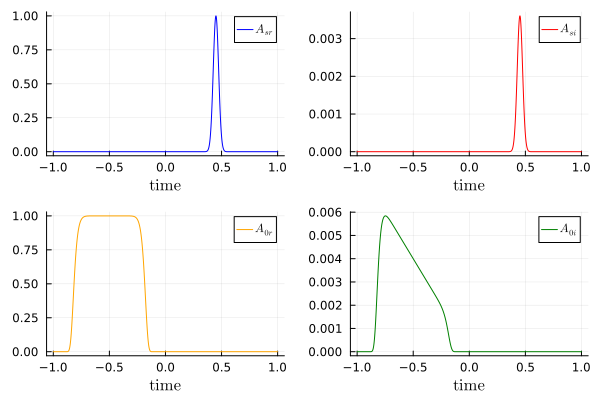

In [17]:
plot(zdomain, [real.(seedpulse) imag.(seedpulse) real.(pumppulse) imag.(pumppulse)], layout = @layout([a b; c d]), label=[L"A_{sr}" L"A_{si}" L"A_{0r}" L"A_{0i}"], color=[:blue :red :orange :green], format=:png)
xlabel!(L"\mathrm{time} ")

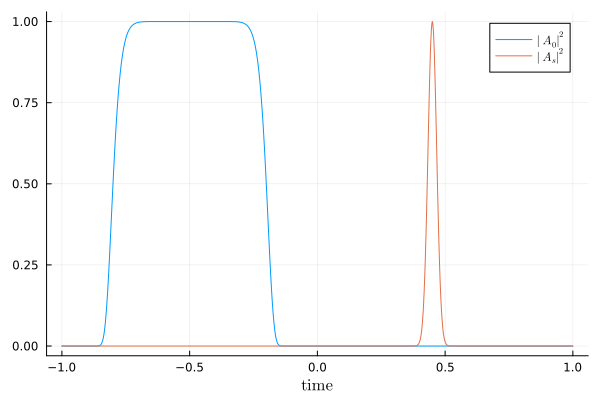

In [18]:
plot(zdomain, pumpint, label=L"|A_{0}|^2", format=:png)
plot!(zdomain, seedint, label=L"|A_{s}|^2",  format=:png)
xlabel!(L"\mathrm{time} ")
# ylabel!(L" | A |^{2} ", rotation=0, yguidefontrotation=-90)

Now let's plot $z$ vs $t$ to see how the pulses move in time across the longitudinal domain

In [19]:
totalz = 2.0 # in normalized units for a total of 2*38
totalzpoints = 1000 # number of data points
dz = (totalz)/totalzpoints #dz
zdomain = [-totalz/2.0+dz*i for i in 0:totalzpoints]; # create an array from -38 m to 38 m

In [20]:
pumppulsezt = [ pumpgaussinit(z, t) for t in tdomain,z in zdomain] ; # create a 2D array with time and z for pump
seedpulsezt = [ seedgaussinit(z, t) for t in tdomain,z in zdomain] ; # create a 2D array with time and z for seed

In [21]:
pumppulseztint = abs2.(pumppulsezt); # intensity |A|^2 of pump
seedpulseztint = abs2.(seedpulsezt); # intensity |A|^2 of seed

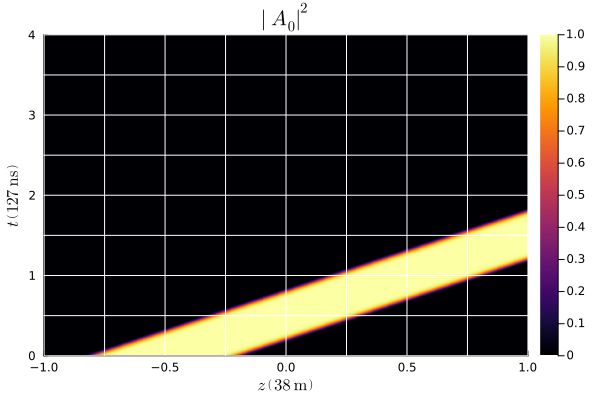

In [22]:
#plot with a heatmap

heatmap( zdomain,tdomain, pumppulseztint, format=:png)
vlinerange = minimum(zdomain):(maximum(zdomain)-minimum(zdomain))/8:maximum(zdomain)
hlinerange = minimum(tdomain):(maximum(tdomain)-minimum(tdomain))/8:maximum(tdomain)
vline!(vlinerange, c=:white, format=:png)
hline!(hlinerange, c=:white, format=:png)
xlabel!(L" z \: \left( 38 \: \mathrm{m} \right)")
ylabel!(L" t \: \left( 127 \: \mathrm{ns} \right)")
plot!(title=L"|A_{0}|^2", legend = false)

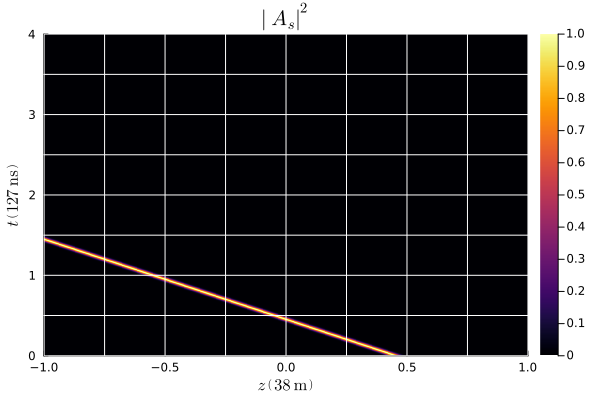

In [23]:
heatmap( zdomain,tdomain, seedpulseztint, format=:png)
vlinerange = minimum(zdomain):(maximum(zdomain)-minimum(zdomain))/8:maximum(zdomain)
hlinerange = minimum(tdomain):(maximum(tdomain)-minimum(tdomain))/8:maximum(tdomain)
vline!(vlinerange, c=:white, format=:png)
hline!(hlinerange, c=:white, format=:png)
xlabel!(L" z \: \left( 38 \: \mathrm{m} \right)")
ylabel!(L" t \: \left( 127 \: \mathrm{ns} \right)")
plot!(title=L"|A_{s}|^2", legend = false)

We thus have our initial conditions at the boundaries

# `Trixi.jl` Model

We will write the 1D Slowly Varying Enevelope Approximation for Optics in TRIXI. The Following equation is found in **Fundamentals of Nonlinear Optics** by Powers (Eqn 10.79)



This is based off the tutorial: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/adding_new_scalar_equations/

and elixer example on advection:
https://github.com/trixi-framework/Trixi.jl/blob/main/examples/structured_2d_dgsem/elixir_advection_basic.jl

and src codes: https://github.com/trixi-framework/Trixi.jl/blob/main/src/equations/maxwell_1d.jl

# Setting up the SVEA (Paraxial Wave) Equation

**NOTE**: `Trixi.jl` uses $x$, $y$, $z$ for the 1st, 2nd, and 3rd dimension. Most optics books use $z$ as the longitudinal direction and $y$,$x$ for the transverse ($\perp$). Because we're doing a 1D simulation in `Trixi.jl` we will use $x$ and $z$ interchageably for the longitudinal direction, and use $y$, $\perp$, $r$ interchangeably for the transverse direction

## Hyperbolic Advection Term

The hyperbolic advection equation is in the form of: 

\begin{equation}
    \frac{\partial}{\partial t} A + v_{g} \frac{\partial}{\partial x} A 
    \tag{28}
\end{equation}

So we need the SBS equations in this form as shown below: 

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{0,r} + \mathbf{c}_0 \cdot \nabla   A_{0,r} &=0 \\
    \partial_{t}   A_{0,i} + \mathbf{c}_0 \cdot \nabla   A_{0,i} &= 0 
    \end{aligned}
    \tag{29}
\end{equation}

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{s,r} + \mathbf{c}_s \cdot \nabla   A_{s,r} &= 0\\
    \partial_{t}   A_{s,i} + \mathbf{c}_{s} \cdot \nabla   A_{s,i} &= 0
    \end{aligned}
    \tag{30}
\end{equation}

The linear hyperbolic advection equation is already implemented in `Trixi.jl`. All we need to do is use the `LinearScalarAdvectionEquation1D()` function which assumes the form of Equation 11. `LinearScalarAdvectionEquation1D()` takes in the user input for the advection velocity ($v_x$). Since the SVEA has only an advection term in the x-direction.

Below we set up the linear hyperbolic advection equation. Note that we need to do this for the real and imaginary parts ($A_{s,r}, A_{s,i}$) and ($A_{0,r}, A_{0,i}$). We put the seed first because we're more interested in that but it doesn't really matter

Let's import various `Trixi.jl` funcitons we need to define our new equations

In [191]:
# Define new physics
using Trixi
using Trixi: AbstractEquations, get_node_vars
import Trixi: varnames, default_analysis_integrals, flux, max_abs_speed_naive,
              have_nonconservative_terms

In [192]:
# Since there is no native support for the Linear Advection equation with two variables
# variables: Asr, Asi, A0r, A0i
struct LinearAdvectionEquation4var1D{T} <: AbstractEquations{1 #= spatial dimension =#,
                                                                   4 #= four variables (Asr, Asi, A0r, A0i) =#}
    advection_speed::T #the advection speed for all 4 variables in 1D so it will be an array with 8 total entries
    Rr::T # SBS gain real part
    Ri::T # SBS gain imaginary
end

We define our new 4-variable, 1-dimension linear sacalar advection equations as shown above. We create a new struct that is a `Trixi.jl` type of `AbstractEquations` (hence the `<:`). `AbstractEquations{a,b}` is a type where the the `a` is the spatial dimensions of the system, and `b` are the variables of the system. 

Notice that we add the `{T <: Real}` to initialize the struct `LinearAdvectionEquatio4var1D` to take in `T` values that belong to the `Real` type of Julia. 

Inside the struct, we want it to hold the speed of light (advection speed) and the SBS gain: `advection_speed` and `Rr` and `Ri`, respectively. These three parameters will be 4-valued arrays for each of the scalar variables: $A_{s,r}$, $A_{s,i}$, $A_{0,r}$, $A_{0,i}$ .

Next we need to define the variable names of our 4-variable, 1-dimensional linear scalar advection equation. The variables will be the real and imaginary part ($A_{0,r}$, $A_{0,i}$, $A_{s,r}$, $A_{s,i}$). These two variables are the conservative and the primitive so we use multiple-dispatch to overload the `Trixi.jl` function `varnames()`

In [193]:
varnames(::typeof(cons2cons), ::LinearAdvectionEquation4var1D) = ("Asr", "Asi", "A0r", "A0i")
varnames(::typeof(cons2prim), ::LinearAdvectionEquation4var1D) = ("Asr", "Asi", "A0r", "A0i")

default_analysis_integrals(::LinearAdvectionEquation4var1D) = ()

default_analysis_integrals (generic function with 6 methods)

### Defining Flux

We need to identify the flux for the 4v1D Linear Advection Equations. The flux is defined as $F$ in the following hyperbolic equaiton:

\begin{equation}
    \partial_{t}   A + \nabla\cdot \mathbf{F} =0
\end{equation}

We can write out our advection equations in a vector of the scalars as follows: 

\begin{equation}
    \partial_t \begin{bmatrix}
    A_{s,r} \\
    A_{s,i} \\
    A_{0,r} \\
    A_{0,i}
    \end{bmatrix} + \partial_{x} \begin{bmatrix}
    F_{s,r} \\
    F_{s,i} \\
    F_{0,r} \\
    F_{0,i}
    \end{bmatrix} = 0
\end{equation}

From equations 29 and 30 we can see that the flux vector is: 

\begin{equation}
    \mathbf{F} = \begin{bmatrix}
    \mathbf{c}_s\\
    \mathbf{c}_s \\
    \mathbf{c}_0 \\
    \mathbf{c}_0\\
    \end{bmatrix} 
    \tag{31}
\end{equation}


As shown above, the flux is just simpy the group velocity ($v_{g}$) which in vacuum is just the speed of light. However, because `TreeMesh()` only allows for square domains so we need to normalize the domain in each direction. This is why we need to have 2-values for the speed and wavenumber

In [194]:
# Calculate 1D flux for a single point
@inline function flux(u, orientation::Integer,
                      equations::LinearAdvectionEquation4var1D)
    Asr, Asi, A0r, A0i = u

    if orientation == 1
        # viscous flux components in the x-direction
        f1 = -equations.advection_speed[1] * Asr
        f2 = -equations.advection_speed[2] * Asi
        f3 = equations.advection_speed[3] * A0r
        f4 = equations.advection_speed[4] * A0i

        return SVector(f1, f2, f3, f4)

    else
        return SVector(0.0, 0.0, 0.0, 0.0)
        
    end
end

flux (generic function with 51 methods)

The flux function requires the input variable (which can be a scalar or vector), orientation (z or x,y directions), and equation type. 

We first unpack the scalar terms from the input variable `u` which should be a vector of the two scalar variables $A_{s,r}$, $A_{s,i}$ , $A_{0,r}$ and $A_{0,i}$. 

Next we return a static vector `SVector()` of the fluxes as shown above. If the direction (`orientation`) is `1` this means it is the flux in the first dimension: $z$. If it is anything other than `orientation == 1` we return a flux of 0 because it is 1D. 

### Defining Speed Limits

We need to calculate the maximum speed possible for our fluxes. We do this by multiple-dispatching the `Trixi.jl` function `max_abs_speed_naive()`. 

In [195]:
# Calculate maximum wave speed for local Lax-Friedrichs-type dissipation
@inline function max_abs_speed_naive(u_ll, u_rr, orientation::Int,
                                     equations::LinearAdvectionEquation4var1D)
    cd = 0.0
    if orientation == 1
        cd = equations.advection_speed[1]
    end
    λ_max = abs(cd)
end

@inline have_constant_speed(::LinearAdvectionEquation4var1D) = True()

@inline function max_abs_speeds(equations::LinearAdvectionEquation4var1D)
    if equations.orientation == 1
        return SVector(equations.advection_speed[1], equations.advection_speed[1], equations.advection_speed[1], equations.advection_speed[1])
    else
        return SVector(0.0, 0.0, 0.0, 0.0)
    end
end

@inline function min_max_speed_hll(u_ll, u_rr, orientation::Integer, equations::LinearAdvectionEquation4var1D)

    return SVector(0.0, 0.0, 0.0, 0.0), SVector(equations.advection_speed[1], equations.advection_speed[1], equations.advection_speed[1], equations.advection_speed[1])
end

min_max_speed_hll (generic function with 1 method)

Additionally, we need to set the maximum absolute speed possible using the `max_abs_speeds()`. Again, this is a `Trixi.jl` function so it will be multiple-dispatched with the `equations::LinearAdvectionEquation2v2D` input type. In this function, it must return the maximum absolute speed for the two variables ($A_r$, $A_i$). THe return function should be a 2-valued `SVector` corresponding to the speeds of $A_r$ and $A_i$. Additionally, the speeds should depend on the direction of the flux (`orientation`).

We are now done creating our new 2-variable, 2-dimensional scalar Advection equations. 

# Boundary Conditions: Dirichlet

For the boundary conditions, we want to have our pulses injected from the left (pump) and from the right (seed). To do this we will use a Dirichlet boundary condition which in `Trixi.jl` is of the form:

```
BoundaryConditionDirichlet()
```

The **Discontinuous Galerkin Method** enforces the boundary conditions *weakly* so that even if they are **Dirichlet**, we can still do things like injecting a value or flux into the simulation.

First, we need to define the boundary conditions on the left and on the right. To do this we need to make a function of the form: 

`function BoundaryCondition(x, t, equation::LinearAdvectionEquation4var1D)`

The input variable `x` will have the current coordinate to calculate but it will be of type `SVector()` so we need to index it with `x[1]` to obtain the first dimensional position. After obtaining the position, we calculate the pump and seed pulse amplitude with the guassian functions: `pumpgaussinit(x[1], t)` and `As/A0*seedgaussinit(x[1], t)`, respectively where we use `As/A0` because we normalize the seed amplitude to the pump aplitude. 

We  next split the real and imaginary parts of the amplitudes and return them as `SVector()`. 

In [365]:
function BCLeftRight(x, t, equation::LinearAdvectionEquation4var1D)
    #get values at x and t
    pumppulse = A0*pumpgaussinit(x[1], t) #+ (1.0 + 1.0im)*1.0e-40
    seedpulse = As*seedgaussinit(x[1], t) #+ (1.0 + 1.0im)*1.0e-40
    #get real and imaginary parts
    A0r = real(pumppulse) #+ sign(real(pumppulse)) * 1.0e-40 #0.0 #real(pumppulse)
    A0i = imag(pumppulse) #+ sign(imag(pumppulse)) * 1.0e-40 #0.0 #imag(pumppulse)
    Asr = real(seedpulse) #+ sign(real(seedpulse)) * 1.0e-40 
    Asi = imag(seedpulse) #+ sign(imag(seedpulse)) * 1.0e-40 


    return SVector(Asr, Asi, A0r, A0i)
    
end

BCLeftRight (generic function with 1 method)

We wrap the BC functions under varaibles:

In [198]:
boundary_condition_L = BCLeftRight
boundary_condition_R = BCLeftRight

BCLeftRight (generic function with 1 method)

Finally, we create a `tuple` for the boundary conditions

In [199]:
boundary_conditions = (x_neg = BoundaryConditionDirichlet(boundary_condition_L),
                       x_pos = BoundaryConditionDirichlet(boundary_condition_R))

(x_neg = BoundaryConditionDirichlet{typeof(BCLeftRight)}(Main.BCLeftRight), x_pos = BoundaryConditionDirichlet{typeof(BCLeftRight)}(Main.BCLeftRight))

# Source Terms

The source terms are the optical absorption, nonlinear Kerr terms along with the time derivatives of our amplitudes:

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{0,r}  &= R_{0,r} \left| A_{s}  \right|^{2}  A_{0,r} - R_{0,i} \left| A_{s}  \right|^{2}  A_{0,i}\\
    \partial_{t}   A_{0,i}  &= R_{0,r} \left| A_{s}  \right|^{2}  A_{0,i} + R_{0,i} \left| A_{s}  \right|^{2}  A_{0,r} 
    \end{aligned}
    \tag{14}
\end{equation}

For the seed: 

\begin{equation}
    \begin{aligned}
    \partial_{t}   A_{s,r}  &= R_{s,r} \left| A_{0}  \right|^{2}  A_{s,r} - R_{s,i} \left| A_{0}  \right|^{2}  A_{s,i}\\
    \partial_{t}   A_{s,i}  &= R_{s,r} \left| A_{0}  \right|^{2}  A_{s,i} + R_{s,i} \left| A_{0}  \right|^{2}  A_{s,r} 
    \end{aligned}
    \tag{15}
\end{equation}



THe documentation of `Trixi.jl` has a page on adding source terms such as those above: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/custom_semidiscretization/#Using-a-custom-ODE-right-hand-side-function


In [200]:
function source_terms_standard(u, x, t, equations::LinearAdvectionEquation4var1D)
    xx = x[1]
    Asr, Asi, A0r, A0i = u

    #need to check if within the SBS cell at x=-0.5 and x=0.5
    #if not there is no source SBS term
    if(xx<-0.5)
        return SVector(0.0,0.0,0.0,0.0)
        
    elseif(xx>0.5)
        return SVector(0.0,0.0,0.0,0.0)
    else
        # intensity
        Asint = abs2.(Asr + 1.0im*Asi)
        A0int = abs2.(A0r + 1.0im*A0i)
        
        Asrsrc = equations.Rr[1]*A0int*Asr - equations.Ri[1]*A0int*Asi #source term for Asr
        Asisrc = equations.Rr[2]*A0int*Asi + equations.Ri[2]*A0int*Asr #source term for Asi
        A0rsrc = equations.Rr[3]*Asint*A0r - equations.Ri[3]*Asint*A0i
        #source term for A0r
        A0isrc = equations.Rr[4]*Asint*A0i + equations.Ri[4]*Asint*A0r #source term for A0i    
        
        return SVector(Asrsrc, Asisrc, A0rsrc, A0isrc)
    end
end

source_terms_standard (generic function with 1 method)

# Putting it All Together

## Initializing Hyperbolic Equations

We need to define our parameters for the `LinearAdvectionEquation4v1D` function:

```
struct LinearAdvectionEquation4var1D{T} <: AbstractEquations{1 #= spatial dimension =#,
                                                                   4 #= four variables (Asr, Asi, A0r, A0i) =#}
    advection_speed::T #the advection speed for all 4 variables in 1D so it will be an array with 8 total entries
    # diffusion_speed::T #the diffusion speed for all 4 variables in 1D so it will be an array with 8 total entries
    light_speed::T #speed of light
    Rr::T # SBS gain real part
    Ri::T # SBS gain imaginary
end
```

In [201]:
advection_speed = [1.0, 1.0, 1.0, 1.0]

Rr = [Rsr, Rsr, R0r, R0r]
Ri = [Rsi, Rsi, R0i, R0i];

In [202]:
Rr

4-element Vector{Float64}:
  0.934090615327568
  0.934090615327568
 -0.9340923747649682
 -0.9340923747649682

In [203]:
Ri

4-element Vector{Float64}:
 -0.10025868072257872
 -0.10025868072257872
 -0.10025886956814646
 -0.10025886956814646

Notice that we also normalized time by the speed of light and total distance of travel. We will use this for the initial conditions

Now let's initialize our hyperbolic equations

In [204]:
#set up for linear terms
equations_hyperbolic = LinearAdvectionEquation4var1D(advection_speed,  Rr, Ri)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearAdvectionEquation4var1D                                                                    │
│ ═════════════════════════════                                                                    │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… Asr                                                              │
│ │ variable 2: …………………………………………… Asi                                                              │
│ │ variable 3: …………………………………………… A0r                                                              │
│ │ variable 4: …………………………………………… A0i                                                              │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [205]:
equations_hyperbolic.Rr, equations_hyperbolic.Ri

([0.934090615327568, 0.934090615327568, -0.9340923747649682, -0.9340923747649682], [-0.10025868072257872, -0.10025868072257872, -0.10025886956814646, -0.10025886956814646])

## Initializing Mesh

We use `TreeMesh()` because it is more flexible. We need to give it the min and maximum coordinates in normalized units which is $z = \left[ -1, 1 \right]$

In [206]:
coordinates_min = (-1.0,) # minimum coordinates (min(x), min(y))
coordinates_max = (1.0,) # maximum coordinates (max(x), max(y))

# cells_per_dimension = (500, 200)
coordinates_min, coordinates_max

((-1.0,), (1.0,))

Depending on how much resolution we  need, we play around with the `initial_refinement_level`

In [208]:
# Create curved mesh with 16 x 16 elements
# cells_per_dimension = cells_per_dimension = (200,)
# mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max; periodicity=false)
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 8,
                n_cells_max = 100_000, periodicity=false)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TreeMesh{1, Trixi.SerialTree{1}}                                                                 │
│ ════════════════════════════════                                                                 │
│ center: …………………………………………………………… [0.0]                                                            │
│ length: …………………………………………………………… 2.0                                                              │
│ periodicity: ……………………………………………… (false,)                                                         │
│ current #cells: ……………………………………… 511                                                              │
│ #leaf-cells: ……………………………………………… 256                                                              │
│ maximum #cells: ……………………………………… 100000                                                           │
└──────────────────────────────────────────────────────────────────────────────────────────

## Initializing the Solver

Once we have done all of this we can create our **DGSEM** solver

In [212]:
basis = LobattoLegendreBasis(3)
surface_flux = flux_lax_friedrichs
solver = DGSEM(basis, surface_flux) #flux_lax_friedrichs,
                # surface_flux=, s

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

## Semidiscretization

We semidescritize: descritize in space but not in time

We use the `TreeMesh()` because it allows for the use of a hyperbolic-parabolic solver via `SemidiscretizationHyperbolicParabolic`

One last thing we need is our initial conditions. The initial conditions must be a function that takes in the inputs `(x, t, equation)` and outputs an `SVector()`: 

In [213]:
initial_condition = (x, t, equations) -> BCLeftRight(x, t, equations)


#35 (generic function with 1 method)

Finally, because we are using hyperbolic equations, we use the `SemidiscretizationHyperbolic` to create the semidiscretization. 

In [214]:
semi = SemidiscretizationHyperbolic(mesh,
                                             equations_hyperbolic,
                                             initial_condition, solver,
                                             boundary_conditions=boundary_conditions, source_terms = source_terms_standard)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… LinearAdvectionEquation4var1D                                    │
│ initial condition: ……………………………… #35                                                              │
│ boundary conditions: ………………………… 2                                                                │
│ │ negative x: …………………………………………… BoundaryConditionDirichlet{typeo…BCLeftRight)}(Main.BCLeftRight) │
│ │ positive x: …………………………………………… BoundaryConditionDirichlet{typeo…BCLeftRight)}(Main.BCLef

# ODE Solver

`Trixi.jl` create an `ODEProblem` from the julia library `DifferentialEquations.jl`. We can then use those solvers. 

**This section is still being worked on**

In [215]:

# callbacks = CallbackSet(SummaryCallback())
time_int_tol = 1.0e-9

1.0e-9

In [216]:
tspan = (0.0, 0.8)
ode = semidiscretize(semi, tspan);

In [217]:
summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 1000)
analysis_interval = 1000
analysis_callback = AnalysisCallback(semi, interval = analysis_interval)
save_solution = SaveSolutionCallback(interval = 20,
                                     save_initial_solution = true,
                                     save_final_solution = true)
callbacks = CallbackSet(summary_callback, alive_callback, analysis_callback);#,save_solution);


In [218]:
visnodes = range(tspan[1], tspan[2], length = 800)

0.0:0.0010012515644555694:0.8

In [220]:
# RadauIIA5(autodiff=false)
# RDPK3SpFSAL49() AutoTsit5(Rosenbrock23()) SSPRK43()
#CarpenterKennedy2N54(williamson_condition = false)

In [221]:
dT = 1.0e-3

0.001

In [223]:
sol = solve(ode, SSPRK43(); dt=dT, adaptive=true, abstol = time_int_tol, reltol = time_int_tol, 
            save_everystep = false, saveat = visnodes, callback = callbacks)
summary_callback() # print the timer summary


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… LinearAdvectionEquation4var1D                                    │
│ initial condition: ……………………………… #35                                                              │
│ boundary conditions: ………………………… 2                                                                

In [224]:
size(sol.t)

(800,)

# Analysis

Quick plot of final time 

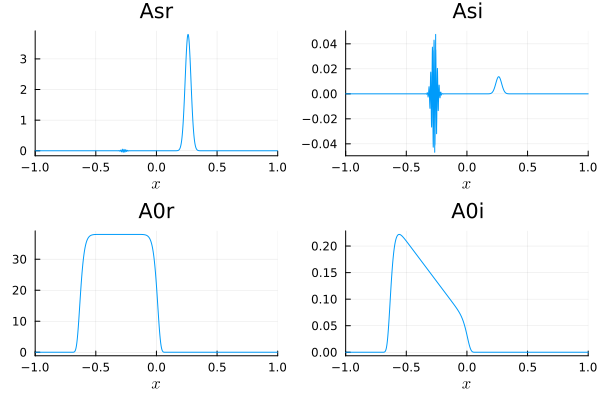

In [316]:
ttt = 190
plot(sol.u[ttt], semi, format=:png)

Now no one really understands what the heck is being plotted or how so we need to find a better, more straightforard way to take a look at the data for the solution. 

We use the `Trixi.jl` funciton `PlotData1D` which converts the output of `DifferentialEquations.jl` funciton `sol` into usable data such as 2D matrices for the variables along with x coordinates. By simply choosing a time step `u[285]` we can get our solution

In [307]:
pd0 = PlotData1D(sol.u[1], semi)
pd1 = PlotData1D(sol.u[ttt], semi)

PlotData1D{Vector{Float64},Matrix{Float64},SVector{4, String},Vector{Float64}}(<x>, <data>, <variable_names>, <mesh_vertices_x>)

In [308]:
seedr0 = pd0.data[:,1] 
seedi0 = pd0.data[:,2];
pumpr0 = pd0.data[:,3] 
pumpi0 = pd0.data[:,4];

seedr = pd1.data[:,1] 
seedi = pd1.data[:,2];
pumpr = pd1.data[:,3] 
pumpi = pd1.data[:,4];

In [309]:
size(seedr0)

(2048,)

In [310]:
seedi[1000]

3.788212489240091e-28

In [311]:
1.0e-30

1.0e-30

In [312]:
Ampseed = @.seedr + 1.0im*seedi;
Amppump = @. pumpr + 1.0im*pumpi;
Amp2seed = abs2.(Ampseed);
Amp2pump = abs2.(Amppump);
TotalAmp = Amp2seed + Amp2pump;

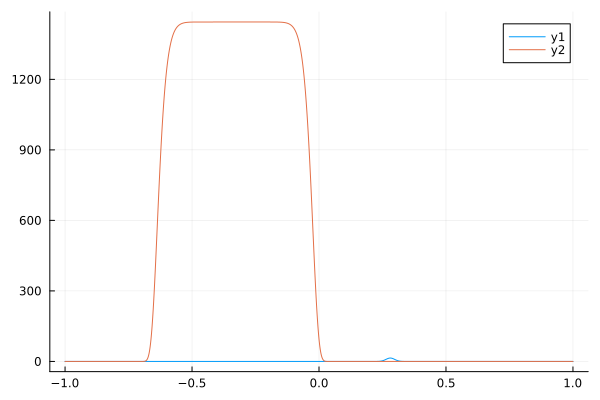

In [313]:
plot( pd1.x,  Amp2seed, format=:png)
plot!( pd1.x,  Amp2pump, format=:png)

In [314]:
maxsi = maximum(abs.(seedi))
maxsr = maximum(abs.(seedr))
maxpi = maximum(abs.(pumpi))
maxpr = maximum(abs.(pumpr))

37.99962055223774

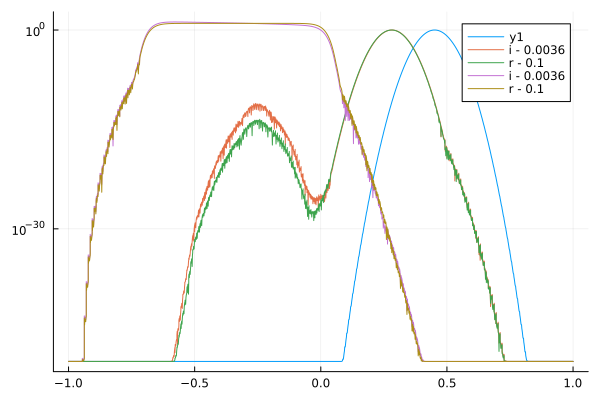

In [315]:
plot(pd1.x, abs.(seedi0./maximum(abs.(seedi0))).+1.0e-50, yscale=:log10, format=:png)
plot!(pd1.x, abs.(seedi./maxsi).+1.0e-50, yscale=:log10, label="i - 0.0036", format=:png)
plot!(pd1.x, abs.(seedr./maxsr).+1.0e-50, yscale=:log10, label="r - 0.1", format=:png)
plot!(pd1.x, abs.(pumpi./maxsi).+1.0e-50, yscale=:log10, label="i - 0.0036", format=:png)
plot!(pd1.x, abs.(pumpr./maxsr).+1.0e-50, yscale=:log10, label="r - 0.1", format=:png)
# plot!(pd1.x, abs.(Amp2pump).+1.0e-50, yscale=:log10, format=:png)

# Split Step

We try doing a split step method by using the `integrator` interface of `OrdinaryDiffEq.jl` . We set up all our equations in the same way but separate the linear and nonlinear. The linear will have no source term. The nonlinear will have no advection but will have a source term

This method seems to be much faster and somewhat more accurate and stable to explosive numerical error. 

In [366]:
#set up for linear terms
equations_hyperbolic_linear = LinearAdvectionEquation4var1D(advection_speed,  Rr, Ri)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearAdvectionEquation4var1D                                                                    │
│ ═════════════════════════════                                                                    │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… Asr                                                              │
│ │ variable 2: …………………………………………… Asi                                                              │
│ │ variable 3: …………………………………………… A0r                                                              │
│ │ variable 4: …………………………………………… A0i                                                              │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [367]:
equations_hyperbolic_nonlinear = LinearAdvectionEquation4var1D([0.0, 0.0, 0.0, 0.0],  Rr, Ri)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearAdvectionEquation4var1D                                                                    │
│ ═════════════════════════════                                                                    │
│ #variables: ………………………………………………… 4                                                                │
│ │ variable 1: …………………………………………… Asr                                                              │
│ │ variable 2: …………………………………………… Asi                                                              │
│ │ variable 3: …………………………………………… A0r                                                              │
│ │ variable 4: …………………………………………… A0i                                                              │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

## Initializing Mesh

We use `TreeMesh()` because it is more flexible. We need to give it the min and maximum coordinates in normalized units which is $z = \left[ -1, 1 \right]$

In [317]:
coordinates_min = (-1.0,) # minimum coordinates (min(x), min(y))
coordinates_max = (1.0,) # maximum coordinates (max(x), max(y))

# cells_per_dimension = (500, 200)
coordinates_min, coordinates_max

((-1.0,), (1.0,))

In [368]:
# Create curved mesh with 16 x 16 elements
# cells_per_dimension = cells_per_dimension = (200,)
# mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max; periodicity=false)
mesh_lin = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 8,
                n_cells_max = 100_000, periodicity=false)

mesh_nonlin = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 8,
                n_cells_max = 100_000, periodicity=false)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ TreeMesh{1, Trixi.SerialTree{1}}                                                                 │
│ ════════════════════════════════                                                                 │
│ center: …………………………………………………………… [0.0]                                                            │
│ length: …………………………………………………………… 2.0                                                              │
│ periodicity: ……………………………………………… (false,)                                                         │
│ current #cells: ……………………………………… 511                                                              │
│ #leaf-cells: ……………………………………………… 256                                                              │
│ maximum #cells: ……………………………………… 100000                                                           │
└──────────────────────────────────────────────────────────────────────────────────────────

In [320]:
basis = LobattoLegendreBasis(3)
surface_flux = flux_lax_friedrichs
solver_lin = DGSEM(basis, surface_flux) #flux_lax_friedrichs,
                # surface_flux=, s
solver_nonlin = DGSEM(basis, surface_flux)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DG{Float64}                                                                                      │
│ ═══════════                                                                                      │
│ basis: ……………………………………………………………… LobattoLegendreBasis{Float64}(polydeg=3)                         │
│ mortar: …………………………………………………………… LobattoLegendreMortarL2{Float64}(polydeg=3)                      │
│ surface integral: ………………………………… SurfaceIntegralWeakForm                                          │
│ │ surface flux: ……………………………………… FluxLaxFriedrichs(max_abs_speed_naive)                           │
│ volume integral: …………………………………… VolumeIntegralWeakForm                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

## Semidiscretization

In [322]:
boundary_condition_L = BCLeftRight
boundary_condition_R = BCLeftRight
boundary_conditions_lin = (x_neg = BoundaryConditionDirichlet(boundary_condition_L),
                       x_pos = BoundaryConditionDirichlet(boundary_condition_R))

initial_condition_lin = (x, t, equations) -> BCLeftRight(x, t, equations)


#39 (generic function with 1 method)

In [323]:
semi_lin = SemidiscretizationHyperbolic(mesh_lin,
                                             equations_hyperbolic_linear,
                                             initial_condition_lin, solver_lin,
                                             boundary_conditions=boundary_conditions_lin) #no source term, source_terms = source_terms_standard)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… LinearAdvectionEquation4var1D                                    │
│ initial condition: ……………………………… #39                                                              │
│ boundary conditions: ………………………… 2                                                                │
│ │ negative x: …………………………………………… BoundaryConditionDirichlet{typeo…BCLeftRight)}(Main.BCLeftRight) │
│ │ positive x: …………………………………………… BoundaryConditionDirichlet{typeo…BCLeftRight)}(Main.BCLef

In [324]:
boundary_condition_nonL = (x, t, equations) -> SVector(0.0, 0.0, 0.0,0.0)
boundary_condition_nonR = (x, t, equations) -> SVector(0.0, 0.0, 0.0,0.0)
boundary_conditions_nonlin = (x_neg = BoundaryConditionDirichlet(boundary_condition_nonL),
                       x_pos = BoundaryConditionDirichlet(boundary_condition_nonR))

initial_condition_nonlin = (x, t, equations) -> SVector(0.0, 0.0, 0.0,0.0)

#45 (generic function with 1 method)

In [325]:
semi_nonlin = SemidiscretizationHyperbolic(mesh_nonlin,
                                             equations_hyperbolic_nonlinear,
                                             initial_condition_nonlin, solver_nonlin,
                                             boundary_conditions=boundary_conditions_nonlin, source_terms = source_terms_standard)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… LinearAdvectionEquation4var1D                                    │
│ initial condition: ……………………………… #45                                                              │
│ boundary conditions: ………………………… 2                                                                │
│ │ negative x: …………………………………………… BoundaryConditionDirichlet{var"#41#42"}(var"#41#42"())           │
│ │ positive x: …………………………………………… BoundaryConditionDirichlet{var"#43#44"}(var"#43#44"())   

# Integrator Interface

In [121]:
function IMEXintegration!(solMat::AbstractArray, linear_int, nonlinear_int, semi, steps::Int64, saveevery::Int64, printout::Bool )
    
    println("Beginning IMEX Integration")
    println("-------------------------------")
    j = 1 #index to which to add to solMat
    printint = ceil(Int64, steps/100)
    for i in 1:steps
        if(printout)
            if mod(i, printint) == 0.0
                println("Step: ", i)
            end
        end
        if mod(i, saveevery) == 0.0
            solMat[:,:,j] .= PlotData1D(linear_int.u, semi).data
            j = j+1
        end
        step!(linear_int)
        reinit!(nonlinear_int, linear_int.u; t0=linear_int.t)
        step!(nonlinear_int)
        reinit!(linear_int, nonlinear_int.u; t0=nonlinear_int.t)        

    end
end

IMEXintegration! (generic function with 1 method)

Set up ODE problems

In [343]:
tspan = (0.0,2.0)
ode_lin = semidiscretize(semi_lin, tspan);
ode_nonlin = semidiscretize(semi_nonlin, tspan);

In [344]:
summary_callback = SummaryCallback()
alive_callback = AliveCallback(alive_interval = 1000)
analysis_interval = 1000
analysis_callback = AnalysisCallback(semi_lin, interval = analysis_interval)
save_solution = SaveSolutionCallback(interval = 20,
                                     save_initial_solution = true,
                                     save_final_solution = true)
callbacks = CallbackSet(summary_callback, alive_callback, analysis_callback);#,save_solution);


In [345]:
dT = 1.0e-3

0.001

Set up integrators

In [346]:
integrator_lin = init(ode_lin,SSPRK33(); adaptive=false, abstol = time_int_tol, reltol = time_int_tol, dt = dT,
            save_everystep = false) ;#, callback = callbacks)

In [347]:
# SSPSDIRK2 ImplicitEuler Rosenbrock23
integrator_nonlin = init(ode_nonlin, Rosenbrock23(autodiff=false,linsolve = KrylovJL_GMRES());  abstol = time_int_tol, reltol = time_int_tol, dt = dT); #, callback = callbacks)

In [369]:
runtime = 0.75 #10*dT
totalsteps = floor(Int64, runtime/(dT))
totalsaves = 200 #ceil(Int64, runtime/(dT*saveevery))
saveevery = ceil(Int64, totalsteps/totalsaves)

totalsteps, saveevery, totalsaves

(750, 4, 200)

In [351]:
sizedata = size(PlotData1D(integrator_lin.u, semi_lin).data)

(2048, 4)

In [370]:
#matrix to save solution at timesteps
Solut = zeros(Float64, (sizedata[1], sizedata[2], totalsaves) );
size(Solut)

(2048, 4, 200)

Begin simulation

In [354]:
IMEXintegration!(Solut, integrator_lin, integrator_nonlin,semi_lin, totalsteps, saveevery,true)

Beginning IMEX Integration
-------------------------------
Step: 8
Step: 16
Step: 24
Step: 32
Step: 40
Step: 48
Step: 56
Step: 64
Step: 72
Step: 80
Step: 88
Step: 96
Step: 104
Step: 112
Step: 120
Step: 128
Step: 136
Step: 144
Step: 152
Step: 160
Step: 168
Step: 176
Step: 184
Step: 192
Step: 200
Step: 208
Step: 216
Step: 224
Step: 232
Step: 240
Step: 248
Step: 256
Step: 264
Step: 272
Step: 280
Step: 288
Step: 296
Step: 304
Step: 312
Step: 320
Step: 328
Step: 336
Step: 344
Step: 352
Step: 360
Step: 368
Step: 376
Step: 384
Step: 392
Step: 400
Step: 408
Step: 416
Step: 424
Step: 432
Step: 440
Step: 448
Step: 456
Step: 464
Step: 472
Step: 480
Step: 488
Step: 496
Step: 504
Step: 512
Step: 520
Step: 528
Step: 536
Step: 544
Step: 552
Step: 560
Step: 568
Step: 576
Step: 584
Step: 592
Step: 600
Step: 608
Step: 616
Step: 624
Step: 632
Step: 640
Step: 648
Step: 656
Step: 664
Step: 672
Step: 680
Step: 688
Step: 696
Step: 704
Step: 712
Step: 720
Step: 728
Step: 736
Step: 744


Analysis

In [355]:
xx = PlotData1D(integrator_lin.u, semi_lin).x;

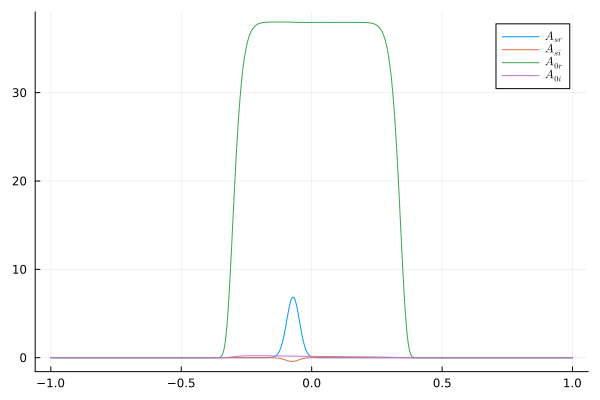

In [358]:
ts = 130
plot(xx, Solut[:,:,ts], label=[L"A_{sr}" L"A_{si}" L"A_{0r}" L"A_{0i}"], format=:png)

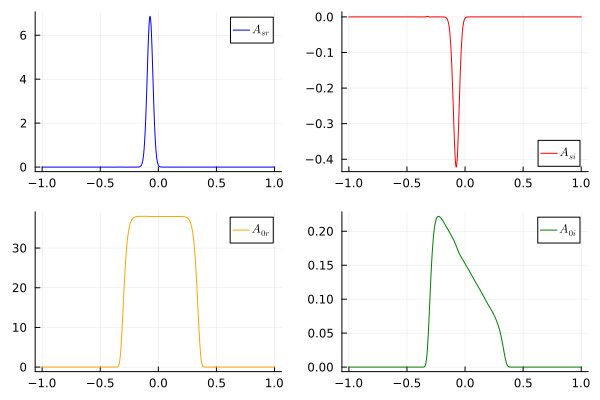

In [359]:
plot(xx, Solut[:,:,ts], layout = @layout([a b; c d]), label=[L"A_{sr}" L"A_{si}" L"A_{0r}" L"A_{0i}"], color=[:blue :red :orange :green], format=:png)#, titlelocation = :left, left_margin = [20mm 0mm], bottom_margin = 10px, xrotation = 60)

In [362]:
seedi0 = Solut[:,2,1]
seedr = Solut[:,1,ts]
seedi = Solut[:,2,ts]
pumpr = Solut[:,3,ts]
pumpi = Solut[:,4,ts];

In [363]:
maxsi = maximum(abs.(seedi))
maxsr = maximum(abs.(seedr))
maxpi = maximum(abs.(pumpi))
maxpr = maximum(abs.(pumpr))

37.99853373850899

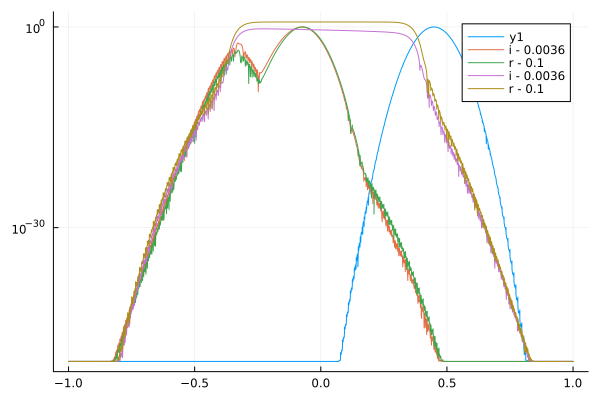

In [364]:
plot(pd1.x, abs.(seedi0./maximum(abs.(seedi0))).+1.0e-50, yscale=:log10, format=:png)
plot!(pd1.x, abs.(seedi./maxsi).+1.0e-50, yscale=:log10, label="i - 0.0036", format=:png)
plot!(pd1.x, abs.(seedr./maxsr).+1.0e-50, yscale=:log10, label="r - 0.1", format=:png)
plot!(pd1.x, abs.(pumpi./maxsi).+1.0e-50, yscale=:log10, label="i - 0.0036", format=:png)
plot!(pd1.x, abs.(pumpr./maxsr).+1.0e-50, yscale=:log10, label="r - 0.1", format=:png)
# plot!(pd1.x, abs.(Amp2pump).+1.0e-50, yscale=:log10, format=:png)

In [181]:
1.0e-45*Rsi*maximum(abs.(seedi)) + 1.0e-45*Rsr*maximum(abs.(seedr))

1.348459269717096e-43

In [500]:
isnonzeroseedi = zeros(Int64, length(pd.x))
isnonzeroseedr = zeros(Int64, length(pd.x))

for i in 1:length(pd.x)

    if abs.(seedi[i]) > 1.0e-49
        isnonzeroseedi[i] = 1
    end
    if abs(seedr[i]) > 1.0e-49
        isnonzeroseedr[i] = 1
    end

end

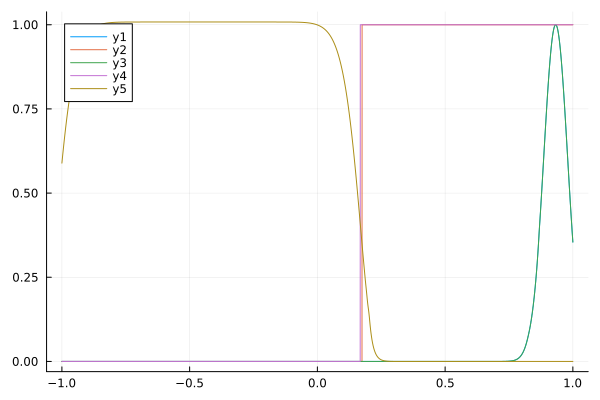

In [983]:
plot(pd.x, seedi./maximum(abs.(seedi)), format=:png)
plot!(pd.x, isnonzeroseedi)
plot!(pd.x, seedr./maximum(abs.(seedr)), format=:png)
plot!(pd.x, isnonzeroseedr)
plot!(pd.x, Amp2pump)

Let's get the variable names

In [636]:
# pd.variable_names

we can see what the actual data looks like below

In [151]:
# pd.data

Now let's actually get the full intensity by adding the real and imaginary parts: $A = A_{r} + i A_{i}$

And squaring the magnitude

In [152]:
Ampseed = @. pd.data[:,1] + 1.0im*pd.data[:,2];
Amppump = @. pd.data[:,3] + 1.0im*pd.data[:,4];
Amp2seed = abs2.(Ampseed);
Amp2pump = abs2.(Amppump);
TotalAmp = Amp2seed + Amp2pump;

We can get the coordinates of the data points by using the `PlotData1D` structure's data of `x` and `y`

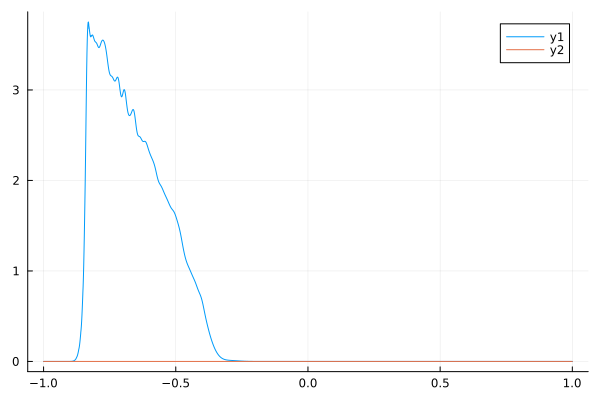

In [153]:
plot( pd.x,  Amp2seed, format=:png)
plot!( pd.x,  Amp2pump, format=:png)
# plot!(ylim=(-0.01,0.01))

## Energy Density

We find the seed energy density at every point on the grid by integrating over time. 

In [154]:
# pd = PlotData1D(sol.u[150], semi)
zdomain = pd.x;
ttdomain = visnodes;
length(zdomain)

2048

In [155]:
seedintens = zeros(Float64, (length(visnodes),length(zdomain)) )


for i in 1:length(visnodes)
    pd = PlotData1D(sol.u[i], semi)
    Ampseed = @. pd.data[:,1] + 1.0im*pd.data[:,2];
    seedintens[i,:]  = @. abs2.(Ampseed);


end

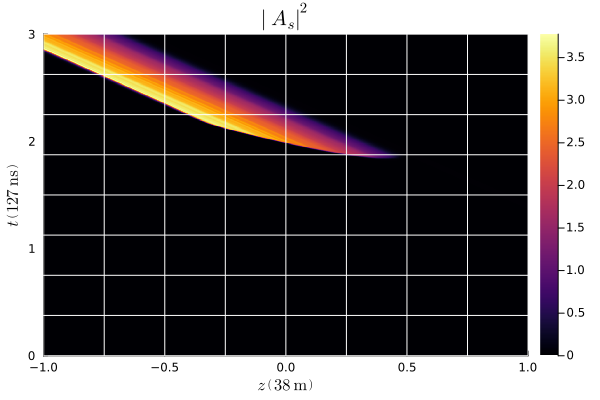

In [156]:
heatmap( zdomain,ttdomain, seedintens, format=:png)
vlinerange = minimum(zdomain):(maximum(zdomain)-minimum(zdomain))/8:maximum(zdomain)
hlinerange = minimum(ttdomain):(maximum(ttdomain)-minimum(ttdomain))/8:maximum(ttdomain)
vline!(vlinerange, c=:white, format=:png)
hline!(hlinerange, c=:white, format=:png)
xlabel!(L" z \: \left( 38 \: \mathrm{m} \right)")
ylabel!(L" t \: \left( 127 \: \mathrm{ns} \right)")
plot!(title=L"|A_{s}|^2", legend = false)

In [157]:
function quad_trap(f,a,b,N) 
    xdomain = b-a
    h = (b-a)/N
    int = h * ( f[1] + f[end] ) / 2.0
    for k=1:N-1
        xk = (b-a) * k/N + a
        int = int + h*f[ceil(Int64,xk/xdomain)]
    end
    return int
end

quad_trap (generic function with 1 method)

In [158]:
size(seedintens)

(1000, 2048)

In [159]:
energydens = zeros(Float64, length(zdomain))

for i in 1:length(ttdomain)
    energydens[i] = quad_trap(seedintens[:,i],0, length(visnodes), length(visnodes)) 

end

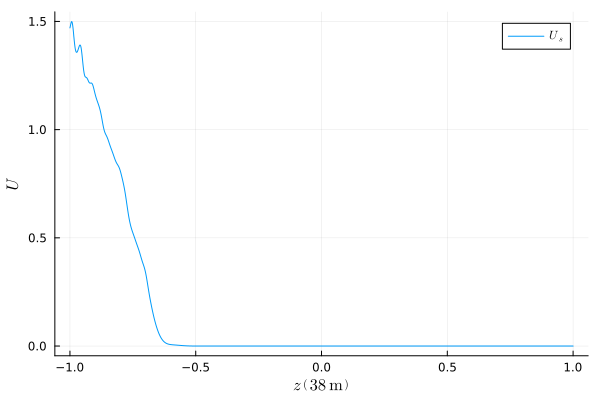

In [160]:
plot(zdomain, energydens, label=L"U_{s}", format=:png)
xlabel!(L" z \: \left( 38 \: \mathrm{m} \right)")
ylabel!(L" U ")